# ISML - Assignment 3

By: **Arpit Gole || a1814270**

In [1]:
# Import Libraries
import warnings
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import matplotlib.ticker as ticker
from operator import itemgetter
from collections import Counter


# Notebook-configurations
warnings.filterwarnings("ignore")
rng = np.random.default_rng()
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [2]:
# Read data
data = pd.read_csv('mnist.csv', header=None)

# Converting data into Numpy Array
X, y = data.iloc[:,1:].to_numpy(copy=True),data.iloc[:,0].to_numpy(copy=True)

## Q1 - Perform PCA on the dataset to reduce each sample into a 10-dimensional feature vector. Show the covariance matrix of the transformed data.

Ans:
- Implementing PCA algorithm.
    - Start
        - Input: n no. of samples as matrix $X$ of $n$ rows and $k$ columns.
        - Calculate the mean for each column. $$mean = \frac {1}{n} \sum \limits _{i=1} ^{n}X_{ij}$$
        - Calculate the centralised matrix $X_C$ and covariance matrix $C$. $$X_C=X-mean$$ $$C = \frac {1}{n}(X_C)^TX_C$$
        - Calculate the eigenvalues and eigenvectors using convariance matrix.
        - Select top x principal components - which are eigen vector corresponding to top x eigen values. Construct matrix $P$.
    - End
    
- Transforming the the data using the principal components (matrix $P$) obtained using the PCA algorithm. $$Transformed \: Data = XP$$
- Calculating the covariance matrix of the transformed data by first centralising it(mean subtracted) and then obtaining the covariance matrix.

In [3]:
# Calculate the mean (Column wise)
mean = X.mean(axis=0)
# Calculate Covariance matrix
covariance_matrix = (X - mean).T @ (X - mean) / (X.shape[0])
print(f"[INFO] Obtained Covariance Matrix with shape = {covariance_matrix.shape} is:\n{covariance_matrix}\n")

# Compute the eigenvalues and eigenvectors using convariance matrix
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

# Selecting top 10 Principal components
no_of_components = 10

# Creating a zip of eigen pairs and sorting in reverse order
# to fetch the top eigen vector corresponding to the eigen values
eigen_pairs = zip(eigen_values, eigen_vectors.T)

principal_components = []
for i in sorted(eigen_pairs, key = lambda x:x[0].real, reverse=True)[:no_of_components]:
    print(f"[INFO] Selecting eigen vector corresponding to the eigen value = {i[0].real}.")
    principal_components.append(i[1].copy())
    
print(f"\n[INFO] Selected 10 principal components with shape = {np.array(principal_components).shape} are =\n{np.array(principal_components)}\n")

# Transforming the data
# Also, fixing the shape (preserving column wise representation)
X_transform = X @ np.array(principal_components).T

# Finding and printing the covariance matrix of the transformed data.
mean_X_transform = X_transform.mean(axis=0)
covariance_matrix_X_transform = (X_transform - mean_X_transform).T @ (X_transform - mean_X_transform) / (X_transform.shape[0])

print(f"[INFO] Obtained Covariance Matrix of the transformed data is of shape = {covariance_matrix_X_transform.shape} is:\n{covariance_matrix_X_transform}\n")

[INFO] Obtained Covariance Matrix with shape = (784, 784) is:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[INFO] Selecting eigen vector corresponding to the eigen value = 5.3047025038408115.
[INFO] Selecting eigen vector corresponding to the eigen value = 3.876370185528712.
[INFO] Selecting eigen vector corresponding to the eigen value = 3.2864987987617957.
[INFO] Selecting eigen vector corresponding to the eigen value = 2.9120555368956107.
[INFO] Selecting eigen vector corresponding to the eigen value = 2.4859176752930585.
[INFO] Selecting eigen vector corresponding to the eigen value = 2.353197154098826.
[INFO] Selecting eigen vector corresponding to the eigen value = 1.7552756066550628.
[INFO] Selecting eigen vector corresponding to the eigen value = 1.5445023624078622.
[INFO] Selecting eigen vector corresponding to the eigen value = 1.4545027291698414.
[INFO] Selecting e

## Q2 - Perform k-means clustering to cluster the dataset (without applying PCA) into 10groups.

Ans:
- Start
    - Input: N: no. of samples; k: the number of clusters.
    - Output: centroids: Calculated k centroids; clusters: assignment of each data point to a centroid.
    1. Initialise k centroids. Initialising them randomly, can use good heuristics.
    2. Run loop
        - (Re)-Assign clusters to each data point based on the smallest Euclidean distance a.k.a E-step.
        - Update the centroids a.k.a M-step.
        - Terminate the loop if the clusters value is same from the previous step.
- End

In [4]:
def e_step(centroids, data_points):
    # Assign clusters to each data point based on the smallest Euclidean distance.
    return np.argmin(distance.cdist(data_points, centroids, 'euclidean'), axis=1)

In [5]:
def m_step(clusters, data_points, k_clusters):
    # Calculate centroid based on the mean of the points in the cluster.
    return np.vstack([data_points[clusters == i].mean(axis=0) for i in
                      tqdm.trange(k_clusters, desc="Finding the mean: ", colour='green', disable=True)])

In [6]:
def k_means(data_points, k_clusters):
    # For choosing the centroids, randomly picking 10 data points.
    centroids = data_points[rng.choice(range(data_points.shape[0]), k_clusters, replace=False), :]

    # Initialising the clusters array
    clusters = np.zeros(data_points.shape[0])

    # Run the procedure until it converges.
    # Here, running loop for fixed size (maximum allowed iterations). It will be a hyperparameter.
    # For us, I'm taking huge range value to guarantee that our dataset always converges within.
    for i in tqdm.trange(10**4, desc="Running the K Means algo for k={0}".format(k_clusters), colour='green', disable=False):
        # E-step
        temp_clusters = e_step(centroids, data_points)
        # M-step
        temp_centroids = m_step(temp_clusters, data_points, k_clusters)
        
        # Terminating condition
        if (clusters == temp_clusters).all():
            break

        # update the values
        clusters = temp_clusters
        centroids = temp_centroids

    return clusters, centroids

In [7]:
clusters, centroids = k_means(X, 10)
print(f"[INFO] Found clusters for all the data points are {clusters} with centers as \n{centroids}")

Running the K Means algo for k=10:   0%|▏                                           | 30/10000 [00:03<17:38,  9.42it/s]

[INFO] Found clusters for all the data points are [2 6 8 ... 2 4 3] with centers as 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Q3 - Please plot the loss curve, that is, the change of loss value of the k-means algorithm with respect to the number of iterations.

Ans:
K-Means algorithm alternates between the following two steps:
- E-step: (Re)-Assigning point to the closest centroid. Fix $\mu_k$, minimize J w.r.t $r_ik$.
- M-step: (Re)-Calculating the centroid means. Fix $r_ik$, minimize J w.r.t $\mu_k$.

K-Means loss function is given by:$$L(X,r_ik,\mu_k)=\sum\limits_{i=1}^{N} \sum\limits_{k=1}^{K} r_ik ||x_n - \mu_k||_2^2$$

Loss after E-step at any time (t) is given by:$$L(X,r_{ik}^{(t)},\mu_{k}^{(t-1)}) \leq L(X,r_{ik}^{(t-1)},\mu_{k}^{(t-1)})$$

Loss after M-step at any time (t) is given by:$$L(X,r_{ik}^{(t)},\mu_{k}^{(t)}) \leq L(X,r_{ik}^{(t-1)},\mu_{k}^{(t)})$$


**P.S.** I have plotted the Loss vs no. of iteration graph based on loss value at each step and after each iteration. Also, I'm training the k-means again here for the sake of similicity.

In [8]:
def calculate_loss(data_points, clusters, centroids):
    # clculate the value of the loss function of K-means.
    return np.sum([np.linalg.norm(val - centroids[index]) ** 2 for index, val in zip(clusters, data_points)])

In [9]:
def k_means_visualise(data_points, k_clusters):
    # For choosing the centroids, randomly picking 10 data points.
    centroids = data_points[rng.choice(range(data_points.shape[0]), k_clusters, replace=False), :]
#     centroids = data_points[np.array([4610, 5376,  738, 2526, 3835, 1127, 4701,  671, 5261,  334]), :]
    
    # Initialising the clusters array
    clusters = np.zeros(data_points.shape[0])

    # Of the form (iteration, loss value)
    plot_data = []

    # Run the procedure until it converges.
    # Here, running loop for fixed size (maximum allowed iterations). It will be a hyperparameter.
    # For us, I'm taking huge range value to guarantee that our dataset always converges within.
    for i in tqdm.trange(1, 10**4, desc="Running the K Means algo for k={0}".format(k_clusters), colour='green', disable=False):
        # E-step
        temp_clusters = e_step(centroids, data_points)
        # Calculate the loss
        plot_data.append((i-0.5, calculate_loss(data_points, temp_clusters, centroids)))
        # M-step
        temp_centroids = m_step(temp_clusters, data_points, k_clusters)
        # Calculate the loss
        plot_data.append((i, calculate_loss(data_points, temp_clusters, temp_centroids)))
        
        # Terminating condition
        if (clusters == temp_clusters).all():
            break

        # update the values
        clusters = temp_clusters
        centroids = temp_centroids

    return clusters, centroids, plot_data

In [10]:
data = k_means_visualise(X, 10)

Running the K Means algo for k=10:   0%|                                             | 15/9999 [00:03<39:20,  4.23it/s]


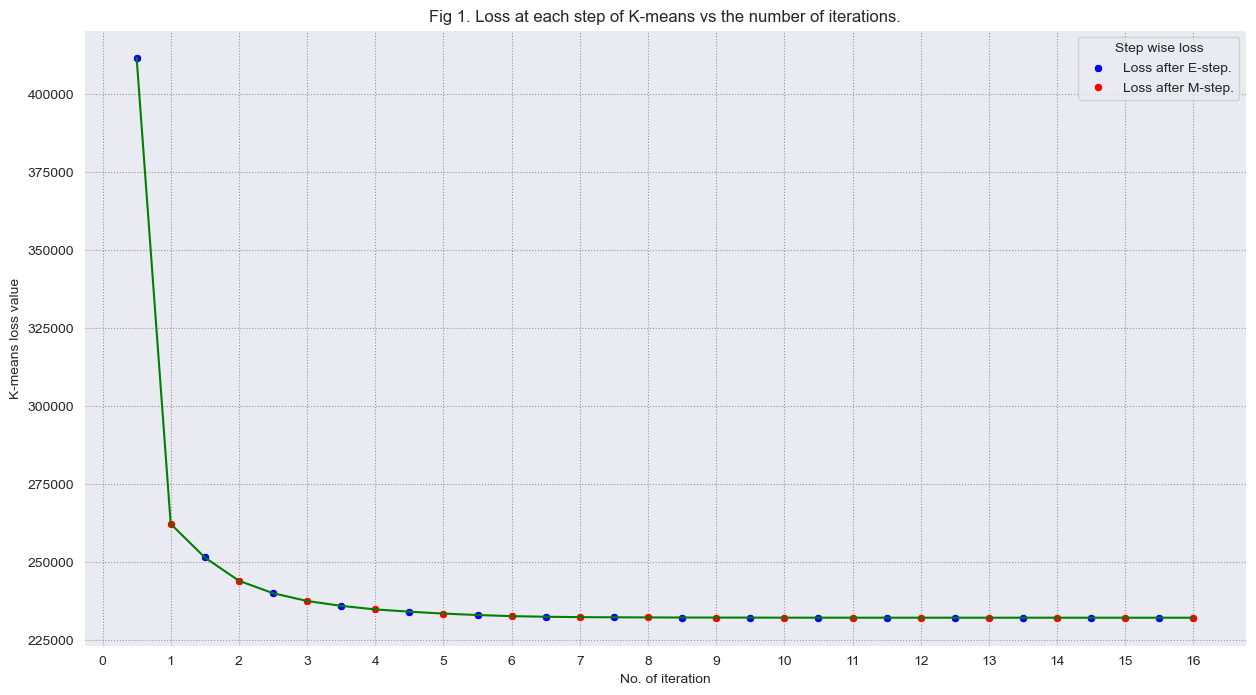

In [11]:
plot_data = np.array(data[2])

# Keeping a little bigger in case too many iterations!
plt.figure(figsize=(15,8))

# Plot the line first
ax = sns.lineplot(plot_data[:, 0], plot_data[:, 1], color='green')
sns.scatterplot(plot_data[::2][:, 0], plot_data[::2][:, 1], ax=ax, color='blue', label='Loss after E-step.')
sns.scatterplot(plot_data[1::2, :][:, 0], plot_data[1::2, :][:, 1], ax=ax, color='red', label='Loss after M-step.')

# Plot asthetics
ax.xaxis.set_major_locator(ticker.MultipleLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_title('Fig 1. Loss at each step of K-means vs the number of iterations.')
ax.set_xlabel('No. of iteration')
ax.set_ylabel('K-means loss value')
ax.legend(title='Step wise loss')

plt.show()

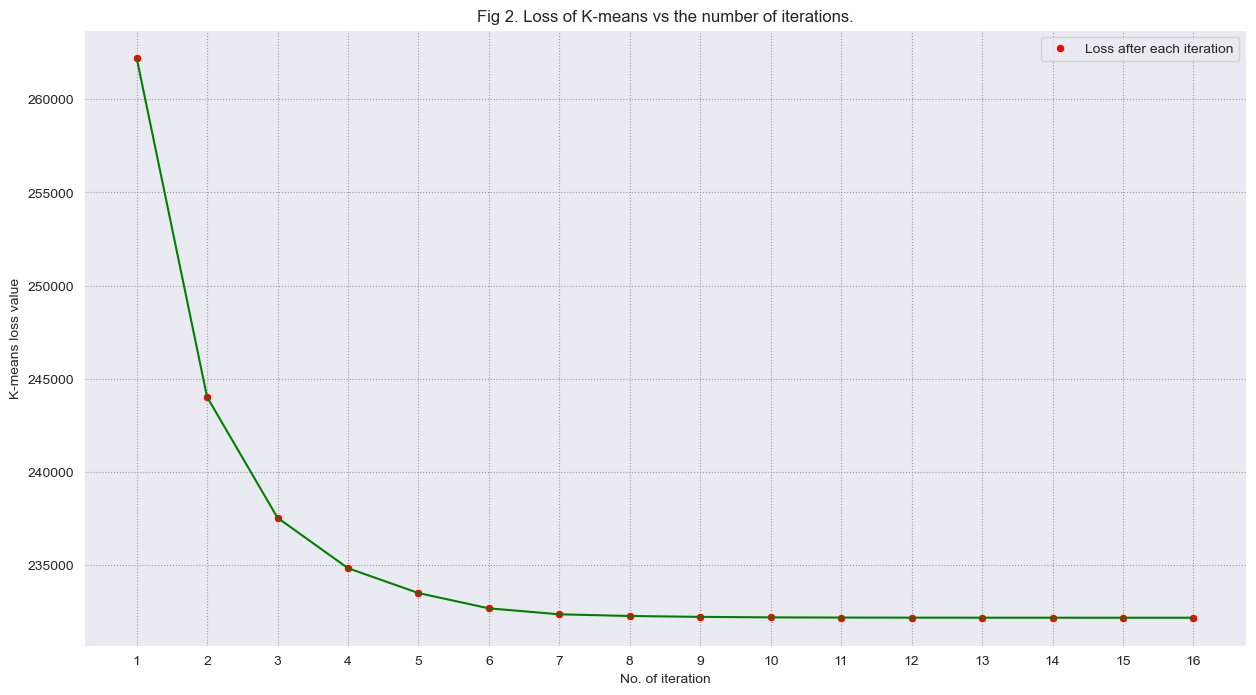

In [12]:
# Keeping a little bigger in case too many iterations!
plt.figure(figsize=(15,8))

# Plot the line first
ax = sns.lineplot(plot_data[1::2, :][:, 0], plot_data[1::2, :][:, 1], color='green')
sns.scatterplot(plot_data[1::2, :][:, 0], plot_data[1::2, :][:, 1], ax=ax, color='red', label='Loss after each iteration')

# Plot asthetics
ax.xaxis.set_major_locator(ticker.MultipleLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_title('Fig 2. Loss of K-means vs the number of iterations.')
ax.set_xlabel('No. of iteration')
ax.set_ylabel('K-means loss value')
ax.legend()

plt.show()

## Q4 - Please use the first 4000 samples as the training set and remaining 2000 samples as the validation set, and design a way to choose the best k in k-means algorithm.

Ans:
- Start
    1. First partition the data set into 2 sets: train and cross-validation set with 4000 and 2000 samples each.
    2. Set the range of k. Let's assume 5 to 20 with step size 2. Ideally set by expereince and imperical calculations.
    3. Select k from above range, train the k means algorithm with the train set.
    4. Output of step 3 will give a cluster assignment of each training data and computed k-centroids.
    5. Use these centroids to find the cluster for each point in the cross-validation set (perform only e-step).
    6. Calculate loss using cross-validation set, clusters (from step 5) and centroids (from step 4).
    7. Keep storing this loss value corresponding to k.
    8. Repeat steps 3, 4, 5, 6 and 7 for different values of k (from step 2).
    9. Finally, plot a graph of Loss vs k values, using data obtained from step 7.
- End

**P.S.** I'm using the helper functions from above whenever necessary.

In [13]:
def choose_optimal_k(train_set, cv_set):    
    # Of the form (k values, loss value on cv set)
    plot_data = []

    for k in tqdm.trange(5, 20, 2, desc="Running the parent loop for different k values", colour='green',
                         disable=False):
        
        # Run K-means algorithm with the selected k
        temp_data = k_means(train_set, k)
        
        # Get the cluster assignment for the cv set
        cv_cluster = e_step(temp_data[1], cv_set)
        
        # Calculate the loss on the cv set
        p_data = calculate_loss(cv_set, cv_cluster, temp_data[1])
        
        # Store the result
        plot_data.append((k, p_data))

    return plot_data

In [14]:
# Partition the data into 2 sets
data_k = choose_optimal_k(X[:4000, :], X[4000:, :])

Running the parent loop for different k values: 100%|████████████████████████████████████| 8/8 [00:17<00:00,  2.23s/it]


In [15]:
print(f"[INFO] Theoretically obtained optimal k value is : {min(data_k, key=itemgetter(1))[0]}.") # Elbow trick to find the optimal k value.

[INFO] Theoretically obtained optimal k value is : 19.


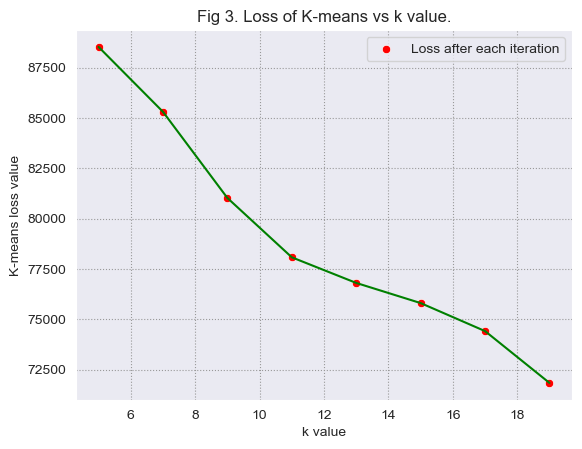

In [16]:
data_k = np.array(data_k)
ax = sns.lineplot(data_k[:, 0], data_k[:, 1], color='green')
sns.scatterplot(data_k[:, 0], data_k[:, 1], ax=ax, color='red', label='Loss after each iteration')

# Plot asthetics
ax.set_title('Fig 3. Loss of K-means vs k value.')
ax.set_xlabel('k value')
ax.set_ylabel('K-means loss value')
ax.legend()

plt.show()

## Q5
Please implement kernel k-means algorithm with RBF-kernel, that is, $$k(\textbf x_i, \textbf x_j) = \text {exp}\displaystyle \Bigg(\frac {-||\textbf x_i - \textbf x_j||_{2}^{2}} {2 \sigma ^2}\displaystyle \Bigg)$$ The hyper-parameter can be empirically set to $$2 \sigma ^2 = \frac {1} {N^2} \sum \limits _{i=1} ^{N} \sum \limits _{j=1} ^{N} ||\textbf x_i - \textbf x_j||_{2}^{2}$$Please only use the first 500 samples and cluster the them into 5 groups.

Ans:
- Start
    - Input: N: no. of samples; k: the number of clusters.
    - Output: clusters: assignment of each data point to a centroid.
    1. Calculating the kernel Matrix $K$.
    2. Pick k initial centroids. Initialise the cluster values $r$ as follows using Kernel-trick $$\textrm{argmin}_{k} ||\phi(\textbf x_i) - \phi(\textbf x_j)||_2^2$$
    3. Run a loop
        - Calculating the assignmnet $$\textbf r_{i}^{t} = \text{assign}(\textbf x_{i}) = ||\phi(\textbf x_{i}) - \frac {\sum _{j} r_{jk}^{t-1}\phi(\textbf x_{j})} {\sum _{j} r_{jk}^{t-1}}||_{2}^{2}$$ Using the kernel trick.
         - Terminate the loop if the clusters value is same from the previous step.
- End


In [17]:
def get_kernel_matrix(data_points):
    # Computing the squared Euclidean distance ||u-v||^2  between the vectors.
    distance_diff = distance.cdist(data_points, data_points, 'sqeuclidean')
    # Computing the 2 \sigma ^ 2 per the formula given described above.
    denominator = np.sum(distance_diff) / data_points.shape[0] ** 2
    return np.exp((-1 / denominator) * distance_diff)

In [18]:
def kernel_k_means(data_points, k_clusters):
    # Obtaining the rbf kernel matrix based on the data.
    kernel_matrix = get_kernel_matrix(data_points)

    # Initialising the clusters using the kernel trick.
    
    # Using the formula 
    #         K(x,x) + K(x',x') -2K(x,x')
    # Here to make the computation fast:
    # 1. We can exclude the first two terms from the calculation. As they will be constants. Doesn't impact the result.
    # 2. Since the third term is a multiple of a negative constant. 
    #     Just change the signs of the elements in the Kernal matrix and assign the cluster to the sample corresponding to the smallest distance
    centroid_indexs = rng.choice(range(data_points.shape[0]), k_clusters, replace=False)
    third_term = kernel_matrix[:, centroid_indexs]
    clusters = np.argmin(-third_term, axis=1)
    
    # OR randomly assign them
    # clusters = rng.choice(range(k_clusters), data_points.shape[0], replace=True)

    cluster_distance = np.zeros((data_points.shape[0], k_clusters))
    
    # Calculating the assignment
    # Run the procedure until it converges.
    # Here, running loop for fixed size (maximum allowed iterations). It will be a hyperparameter.
    # For us, I'm taking huge range value to guarantee that our dataset always converges within.
    for i in tqdm.trange(10**4, desc="Running the kernel K Means algo for k={0}".format(k_clusters)):
        
        # Counting the number of data points in each cluster
        cluster_count = Counter(clusters)
        
        # Running a loop over the cluster to compute the kernel trick
        for k in range(k_clusters):
            
            # Each r'_j can be viewed as 1/Occurances of a particular cluster.
            denominator = cluster_count[k]
            
            # Here to make the computation fast:
            # 1. Excluding the first term - As its a constant value and doesn't affect the output.
            # 2. Computing the second term once per data point.
            # 3. The third term is fixed for the cluster k. It's computed and same value is assigned to 
            #    each data point within a cluster.
            cluster_distance[:, k] -= 2 * np.sum(((1/denominator) * kernel_matrix[:, clusters == k]), axis=1)

            cluster_distance[:, k] += np.sum(((1/(denominator ** 2)) * kernel_matrix[clusters == k][:, clusters == k]))
            
        # Updating the clusters
        temp_clusters = np.argmin(cluster_distance, axis=1)
        
        # Terminating condition
        if (clusters == temp_clusters).all():
            break
            
        # update the values
        clusters = temp_clusters
        cluster_distance.fill(0)

    return clusters

In [19]:
clusters = kernel_k_means(X[:500, :], 5)
print(f"[INFO] Obatined clusters with RBF-kernel are as follows: {clusters}")

Running the kernel K Means algo for k=5:   0%|                                     | 12/10000 [00:00<00:21, 473.10it/s]

[INFO] Obatined clusters with RBF-kernel are as follows: [4 0 1 2 1 3 2 4 2 1 4 2 4 3 2 1 3 4 3 1 3 0 1 2 1 4 1 4 4 1 1 4 3 1 4 1 3
 0 1 3 2 4 1 1 1 1 1 1 1 4 4 0 1 2 1 4 0 1 1 2 3 1 3 0 3 2 3 2 0 4 2 1 2 3
 4 4 2 2 2 1 4 4 3 3 1 4 1 1 0 1 3 1 1 3 4 0 1 4 4 2 1 1 2 1 2 2 3 4 0 1 1
 4 2 2 0 1 1 4 0 0 4 0 3 1 2 4 3 1 2 3 4 1 2 1 1 4 4 2 4 1 1 1 1 1 4 1 4 3
 1 4 1 3 2 1 1 3 0 4 1 3 1 4 1 1 3 3 1 1 2 4 1 3 1 2 2 1 1 2 3 4 2 4 4 1 2
 1 3 3 1 3 3 1 0 1 1 1 1 4 4 3 2 2 4 4 3 2 0 4 2 0 1 2 1 3 1 4 4 1 3 4 4 3
 3 1 4 4 1 1 1 0 1 2 3 3 0 4 4 1 3 4 2 3 4 1 4 4 0 1 2 0 1 2 2 3 4 4 2 1 1
 1 1 3 3 1 1 4 4 1 1 2 2 1 1 1 4 1 2 3 3 4 1 4 1 0 4 1 3 1 1 1 2 4 1 0 3 4
 0 1 4 3 2 1 3 0 1 1 0 1 3 2 2 3 4 1 1 2 4 3 2 1 0 4 1 3 1 3 0 4 4 1 4 3 4
 4 1 1 1 1 1 3 1 4 1 4 1 2 4 3 4 1 1 2 4 1 1 2 4 2 2 0 2 4 1 1 1 3 2 3 4 1
 2 1 1 1 1 3 4 1 3 1 3 3 2 1 1 3 4 1 1 1 4 3 4 4 2 3 4 2 2 0 3 3 1 1 4 4 2
 1 2 1 2 1 1 1 3 4 2 1 1 1 1 3 1 1 1 4 1 0 1 0 3 3 3 4 1 0 1 1 1 4 0 1 1 2
 2 4 1 2 3 3 2 3 4 0 2 2 4 3 0 1 1 1 0 1 0 

THE END